<a href="https://colab.research.google.com/github/malofeevakate/E-commerce_project/blob/main/e_commerce_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import timedelta

### Посмотрим на таблицу с уникальными идентификаторами пользователей

In [ ]:
df_customers = pd.read_csv('olist_customers_dataset.csv')

In [ ]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
df_customers.shape

(99441, 5)

In [ ]:
# пропущенные значения отсутствуют
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [ ]:
# сравним число юников айди юзеров и айди юзеров, связанных с заказами
df_customers.customer_id.nunique()

99441

In [ ]:
df_customers.customer_unique_id.nunique()

96096

Мы видим, что юников меньше, чем айди юзеров, связанных с заказами, что логично (некоторые пользователи делают больше одного заказа)

## Посмотрим на таблицу с данными заказов

In [ ]:
df_orders = pd.read_csv('olist_orders_dataset.csv')

In [ ]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
df_orders.shape

(99441, 8)

In [ ]:
# посмотрим на типы данных, в первую очередь нас интересует тип временных переменных
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [ ]:
# преобразуем форматы временных переменных в timestamp
df_orders.order_purchase_timestamp = pd.to_datetime(df_orders.order_purchase_timestamp)
df_orders.order_approved_at = pd.to_datetime(df_orders.order_approved_at)
df_orders.order_delivered_carrier_date = pd.to_datetime(df_orders.order_delivered_carrier_date)
df_orders.order_delivered_customer_date = pd.to_datetime(df_orders.order_delivered_customer_date)
df_orders.order_estimated_delivery_date = pd.to_datetime(df_orders.order_estimated_delivery_date)

In [ ]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Обратим внимание, что имеются пропущенные данные в датах перемещения заказов:  
    - из всех созданных заказов по 160 заказам не подтвердилась оплата,  
    - 1783 заказа не переданы в доставку,  
    - 2965 заказов не доставлены конечным пользователям

In [ ]:
# а что вобще по статусам заказов?
df_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# посмотрим подробнее на заказы со статусом delivered:
df_orders.query('order_status == "delivered"').isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [ ]:
df_orders.query('order_delivered_customer_date == order_delivered_customer_date').value_counts('order_status')

order_status
delivered    96470
canceled         6
dtype: int64

In [ ]:
df_orders.groupby('order_status', as_index = False).count()

,order_status,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,approved,2,2,2,2,0,0,2
1,canceled,625,625,625,484,75,6,625
2,created,5,5,5,0,0,0,5
3,delivered,96478,96478,96478,96464,96476,96470,96478
4,invoiced,314,314,314,314,0,0,314
5,processing,301,301,301,301,0,0,301
6,shipped,1107,1107,1107,1107,1107,0,1107
7,unavailable,609,609,609,609,0,0,609


Анализ данных в разрезе статусов заказов показал, что порядка 97 % заказов с датой доставки клиенту имеют статус delivered. При этом, если опираться только на статус delivered, мы видим, что:  
- доставлено 14 заказов с отсутствующей датой подтверждения оплаты. Все они приходятся на даты заказов 19.01.2017, 17.02.2017 - 19.02.2017, разные юники, разные города. Если предположить, что эти юзеры - должники нашей системы (товар получили, но не оплатили), значит, эта опция доступна какому-то количеству пользователей, почему воспользовавшихся ею так мало за рассматриваемый период? Скорее всего какой - то баг в системе подтверждения оплаты или ее учета, поэтому оставляю в выборке доставленных и оплаченных заказов),
- 2 заказа с отсутствующей датой передачи заказа в логистику,  
- 8 заказов с отсутствующей датой вручения клиенту (почти все невручения приходятся на один и тот же штат - Сан Паулу, вроде и небольшая доля в общем объеме наших заказов, но брать их в выборку купленных не хочется).
Ввиду того, что покупка - это оплата и получение товара клиентом (в совокупности), а также необходимости сделать метрику более чувствительной к отказам от покупки заказов на разных этапах, целесообразно **признать покупкой транзакцию, у которой статус "доставлено" + имеется дата передачи клиенту**

## Посмотрим на таблицу с данными товарных позиций, входящих в заказы

In [ ]:
df_items = pd.read_csv('olist_order_items_dataset.csv')

In [ ]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
df_items.shape

(112650, 7)

In [ ]:
df_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [ ]:
# переведем планируемую дату доставки в более подходящий формат
df_items.shipping_limit_date = pd.to_datetime(df_items.shipping_limit_date)

In [ ]:
df_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

что такое order_item_id? посмотрим на примере order_id == 00143d0f86d6fbd9f9b38ab440ac16f5:

In [ ]:
# данный заказ хранится в таблице заказов
df_orders.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


In [ ]:
# и в таблице товаров, входящих в заказы. При чем мы видим, что в данный заказ входит 3 единицы одного и того же товара
# таким образом, в order_item_id хранится порядковый номер заказанного товара (а количество строк в данном заказе = количество товаров)
df_items.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


Заметим, что в таблице товаров, входящих в заказы, есть информация не обо всех заказах (по 775 заказам данных нет):

In [ ]:
df_orders.order_id.nunique()

99441

In [ ]:
df_items.order_id.nunique()

98666

### Для определения пользователей, совершивших покупку только один раз, смержим дату клиентов с датой заказов:

In [ ]:
df_customers_orders = df_orders.merge(df_customers)

In [ ]:
df_customers_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [ ]:
df_customers_orders.shape

(99441, 12)

In [ ]:
df_customers_orders.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)') \
.groupby('customer_unique_id', as_index = False) \
.agg({'customer_id' : 'count'}) \
.rename(columns = {'customer_id' : 'count_orders'}) \
.query('count_orders < 2')

,customer_unique_id,count_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,1
93346,fffea47cd6d3cc0a88bd621562a9d061,1
93347,ffff371b4d645b6ecea244b27531430a,1
93348,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
df_customers_orders['year'] = df_customers_orders.order_purchase_timestamp.dt.year

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f06f4b978>]],
      dtype=object)

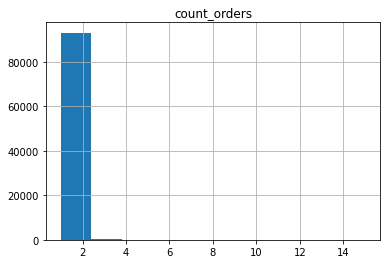

In [ ]:
df_customers_orders.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)') \
.groupby('customer_unique_id', as_index = False) \
.agg({'customer_id' : 'count'}) \
.rename(columns = {'customer_id' : 'count_orders'}) \
.hist()

In [ ]:
df_customers_orders.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)') \
.groupby('customer_unique_id', as_index = False) \
.agg({'customer_id' : 'count'}) \
.rename(columns = {'customer_id' : 'count_orders'}) \
.query('count_orders < 2')

,customer_unique_id,count_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,1
93346,fffea47cd6d3cc0a88bd621562a9d061,1
93347,ffff371b4d645b6ecea244b27531430a,1
93348,ffff5962728ec6157033ef9805bacc48,1


Итак, больше 90 % наших юзеров (90 549) совершает покупку единожды

### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам):

какие заказы мы можем считать недоставленными? Те, у кого нет статуса delivered, на дату доставки не смотрим, так как выше мы установили, что дата доставки имеется у двух видов заказов - доставленных и отмененных, а вторые нам потребуются

In [ ]:
df_not_delivered = df_orders.query('order_status != "delivered"') \
.groupby('order_status', as_index = False) \
.agg({'order_id' : 'count'}) \
.rename(columns={'order_id': 'total_not_delivered'})

In [ ]:
# а сколько всего месяцев в рассматриваемой выборке?
total_month= (df_orders.order_purchase_timestamp.max() - df_orders.order_purchase_timestamp.min())/np.timedelta64(1, 'M')

In [ ]:
df_not_delivered['avg_not_delivered_per_month'] = df_not_delivered.total_not_delivered / total_month

In [ ]:
df_not_delivered.sort_values('avg_not_delivered_per_month', ascending = False)

,order_status,total_not_delivered,avg_not_delivered_per_month
5,shipped,1107,43.596938
1,canceled,625,24.614351
6,unavailable,609,23.984223
3,invoiced,314,12.366250
4,processing,301,11.854271
2,created,5,0.196915
0,approved,2,0.078766


Видно, что наибольшая доля недоставленных заказов застревает на этапе отгрузки со склада. Так же в топ - 3 есть отмененные заказы, и по каким-то причинам недоступные. Показательно, что доля неподтвержденных и неоплаченных заказов минимальна.

### Для опредения топового дня недели по каждому товару смерджим дату заказов с датой товаров в этих заказах (при этом учитываем, что по 775 заказам нет данных об их составе в таблице df_items):

In [ ]:
df_items_orders = df_items.merge(df_orders)

In [ ]:
df_items_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [ ]:
df_items_orders['weekday'] = df_items_orders.order_purchase_timestamp.dt.day_name()

In [ ]:
df_products_weekday = pd.pivot_table(df_items_orders, index = 'product_id', columns = 'weekday', values = 'order_id', aggfunc = 'count').fillna(0)

In [ ]:
df_products_weekday

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0
fff9553ac224cec9d15d49f5a263411f,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_products_weekday['top_day'] = df_products_weekday.idxmax(axis=1)

In [ ]:
# результат представлен в колонке weekday. Следует обратить внимание, что в некоторых случаях топ-дней у того или иного товара более одного (например, товар с product_id = 000b8f95fcb9e0096488278317764d19)
pd.DataFrame(df_products_weekday.where(df_products_weekday.eq(df_products_weekday.max(1), axis=0)).stack()).rename(columns={0 : 'count_orders'})

count_orders
product_id                       weekday               
00066f42aeeb9f3007548bb9d3f33c38 Sunday               1
00088930e925c41fd95ebfe695fd2655 Tuesday              1
0009406fd7479715e4bef61dd91f2462 Thursday             1
000b8f95fcb9e0096488278317764d19 Friday               1
                                 Wednesday            1
...                                                 ...
fff6177642830a9a94a0f2cba5e476d1 Sunday               1
fff81cc3158d2725c0655ab9ba0f712c Monday               1
fff9553ac224cec9d15d49f5a263411f Friday               1
fffdb2d0ec8d6a61f0a0a0db3f25b441 Tuesday              2
fffe9eeff12fcbd74a2f2b007dde0c58 Wednesday            1

[42705 rows x 1 columns]

### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Посчитаем общее количество покупок по каждому пользователю в месяц, и поделим эти суммы на число недель в соответствующем месяце

In [ ]:
# выберем нужные колонки (юник и дата покупки) для тех пользователей, которые, как мы ранее определили, совершили завершенные покупки
df_customers_order_purchase = df_customers_orders.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)')[['customer_unique_id', 'order_purchase_timestamp']]

In [ ]:
df_customers_order_purchase

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39
...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27


In [ ]:
# создадим колонки с годом и месяцем
df_customers_order_purchase['month'] = df_customers_order_purchase.order_purchase_timestamp.dt.month
df_customers_order_purchase['year'] = df_customers_order_purchase.order_purchase_timestamp.dt.year

In [ ]:
df_customers_order_purchase.head()

,customer_unique_id,order_purchase_timestamp,month,year
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,10,2017
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,7,2018
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,8,2018
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,11,2017
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2,2018


In [ ]:
# сделаем справочную таблицу с количеством недель в соответствующих месяцев
df_m_y = pd.DataFrame(df_customers_order_purchase.order_purchase_timestamp)

In [ ]:
df_m_y

,order_purchase_timestamp
0,2017-10-02 10:56:33
1,2018-07-24 20:41:37
2,2018-08-08 08:38:49
3,2017-11-18 19:28:06
4,2018-02-13 21:18:39
...,...
99436,2017-03-09 09:54:05
99437,2018-02-06 12:58:58
99438,2017-08-27 14:46:43
99439,2018-01-08 21:28:27


In [ ]:
df_m_y['month'] = df_m_y.order_purchase_timestamp.dt.month
df_m_y['year'] = df_m_y.order_purchase_timestamp.dt.year

In [ ]:
df_m_y.month = df_m_y.month.apply(lambda x: str(x))
df_m_y.year = df_m_y.year.apply(lambda x: str(x))

In [ ]:
df_m_y

,order_purchase_timestamp,month,year
0,2017-10-02 10:56:33,10,2017
1,2018-07-24 20:41:37,7,2018
2,2018-08-08 08:38:49,8,2018
3,2017-11-18 19:28:06,11,2017
4,2018-02-13 21:18:39,2,2018
...,...,...,...
99436,2017-03-09 09:54:05,3,2017
99437,2018-02-06 12:58:58,2,2018
99438,2017-08-27 14:46:43,8,2017
99439,2018-01-08 21:28:27,1,2018


In [ ]:
df_m_y['m_y'] = df_m_y.year + '/' + df_m_y.month

In [ ]:
df_m_y['day_in_month'] = df_m_y.order_purchase_timestamp.dt.daysinmonth

In [ ]:
df_m_y['weeks_in_month'] = round((df_m_y.day_in_month / 7), 2)

In [ ]:
df_m_y

,order_purchase_timestamp,month,year,m_y,day_in_month,weeks_in_month
0,2017-10-02 10:56:33,10,2017,2017/10,31,4.43
1,2018-07-24 20:41:37,7,2018,2018/7,31,4.43
2,2018-08-08 08:38:49,8,2018,2018/8,31,4.43
3,2017-11-18 19:28:06,11,2017,2017/11,30,4.29
4,2018-02-13 21:18:39,2,2018,2018/2,28,4.00
...,...,...,...,...,...,...
99436,2017-03-09 09:54:05,3,2017,2017/3,31,4.43
99437,2018-02-06 12:58:58,2,2018,2018/2,28,4.00
99438,2017-08-27 14:46:43,8,2017,2017/8,31,4.43
99439,2018-01-08 21:28:27,1,2018,2018/1,31,4.43


In [ ]:
# результирующая справочная таблица
df_month_week = df_m_y.groupby('m_y', as_index = False) \
.agg({'weeks_in_month' : 'mean'})

In [ ]:
# получим количество покупок в месяц для каждого юника
df_customers_count_orders = df_customers_order_purchase.groupby(['customer_unique_id', 'month', 'year'], as_index = False) \
.agg({'order_purchase_timestamp' : 'count'}) \
.rename(columns = {'order_purchase_timestamp' : 'count_orders'}) \
.sort_values('count_orders', ascending = False)

In [ ]:
df_customers_count_orders

,customer_unique_id,month,year,count_orders
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,6
60365,a239b8e2fbce33780f1f1912e2ee5275,2,2017,4
65765,b08fab27d47a1eb6deda07bfd965ad43,9,2017,4
14054,25a560b9a6006157838aab1bdbd68624,4,2017,4
67354,b4e4f24de1e8725b74e4a1f4975116ed,2,2018,4
...,...,...,...,...
31897,55a82b1881c249c04755d69057227ece,6,2018,1
31896,55a5d857599f61f045f9956f9180262d,7,2018,1
31895,55a55b65ef7f279bf0e5846a645e5ba6,12,2017,1
31894,55a4c5ebfd8fcc86eb83882fa0464977,1,2018,1


In [ ]:
df_customers_count_orders.month = df_customers_count_orders.month.apply(lambda x: str(x))
df_customers_count_orders.year = df_customers_count_orders.year.apply(lambda x: str(x))

In [ ]:
df_customers_count_orders['m_y'] = df_customers_count_orders.year + '/' + df_customers_count_orders.month

In [ ]:
# таблица по юникам для мерджа справочной таблицы с количеством недель
df_customers_count_orders

,customer_unique_id,month,year,count_orders,m_y
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,6,2017/1
60365,a239b8e2fbce33780f1f1912e2ee5275,2,2017,4,2017/2
65765,b08fab27d47a1eb6deda07bfd965ad43,9,2017,4,2017/9
14054,25a560b9a6006157838aab1bdbd68624,4,2017,4,2017/4
67354,b4e4f24de1e8725b74e4a1f4975116ed,2,2018,4,2018/2
...,...,...,...,...,...
31897,55a82b1881c249c04755d69057227ece,6,2018,1,2018/6
31896,55a5d857599f61f045f9956f9180262d,7,2018,1,2018/7
31895,55a55b65ef7f279bf0e5846a645e5ba6,12,2017,1,2017/12
31894,55a4c5ebfd8fcc86eb83882fa0464977,1,2018,1,2018/1


In [ ]:
# мерджим к таблице юников справочную инфу
df_orders_week = df_customers_count_orders.merge(df_month_week, how = 'left', on = 'm_y')

In [ ]:
df_orders_week.head()

,customer_unique_id,month,year,count_orders,m_y,weeks_in_month
0,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,6,2017/1,4.43
1,a239b8e2fbce33780f1f1912e2ee5275,2,2017,4,2017/2,4.00
2,b08fab27d47a1eb6deda07bfd965ad43,9,2017,4,2017/9,4.29
3,25a560b9a6006157838aab1bdbd68624,4,2017,4,2017/4,4.29
4,b4e4f24de1e8725b74e4a1f4975116ed,2,2018,4,2018/2,4.00


In [ ]:
# создаем соответствующий столбец
df_orders_week['count_orders_week'] = df_orders_week.count_orders / df_orders_week.weeks_in_month

In [ ]:
# результирующие данные содержатся в столбце count_orders_week
df_orders_week.sort_values('customer_unique_id', ascending = False)

,customer_unique_id,month,year,count_orders,m_y,weeks_in_month,count_orders_week
95185,ffffd2657e2aad2907e67c3e9daecbeb,5,2017,1,2017/5,4.43,0.225734
32130,ffff5962728ec6157033ef9805bacc48,5,2018,1,2018/5,4.43,0.225734
32131,ffff371b4d645b6ecea244b27531430a,2,2017,1,2017/2,4.00,0.250000
32132,fffea47cd6d3cc0a88bd621562a9d061,12,2017,1,2017/12,4.43,0.225734
32133,fffcf5a5ff07b0908bd4e2dbc735a684,6,2017,1,2017/6,4.29,0.233100
...,...,...,...,...,...,...,...
63674,0004aac84e0df4da2b147fca70cf8255,11,2017,1,2017/11,4.29,0.233100
63675,0000f6ccb0745a6a4b88665a16c9f078,10,2017,1,2017/10,4.43,0.225734
63676,0000f46a3911fa3c0805444483337064,3,2017,1,2017/3,4.43,0.225734
79505,0000b849f77a49e4a4ce2b2a4ca5be3f,5,2018,1,2018/5,4.43,0.225734


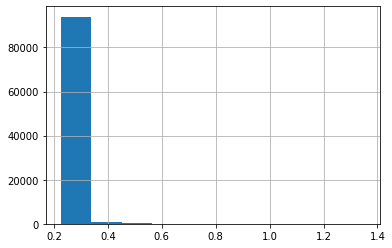

In [ ]:
df_orders_week.count_orders_week.hist()

### Когортный анализ пользователей за период с января по декабрь (найти  когорту с самым высоким retention на 3й месяц)

Поскольку на предыдущем этапе мы заметили, что более 90 % наших клиентов сделали только по одной покупке, можно ожидать маленький ретеншн. Возьмем пользователей, совершивших покупки в 2017 году

In [ ]:
df_cohort = df_customers_orders.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)')

In [ ]:
# для фильтрации данных за 2017 год добавим графу год, и отберем по ней интересующих нас юников
df_cohort['year'] = df_cohort.order_purchase_timestamp.dt.year

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_cohort = df_cohort.query('year == "2017"')

In [ ]:
df_cohort

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99433,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017


In [ ]:
# сохраняем только релевантные столбцы - юники и дата заказа
df = df_cohort[['customer_unique_id', 'order_purchase_timestamp']]

In [ ]:
# создадим колонку с указанием когорты (месячная когорта на основе даты первой покупки)
df['cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp'] \
.transform('min') \
.dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# добавим усеченный месяц даты покупки
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df

,customer_unique_id,order_purchase_timestamp,cohort,order_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09,2017-10
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07,2017-07
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05,2017-05
8,39382392765b6dc74812866ee5ee92a7,2017-01-23 18:29:09,2017-01,2017-01
...,...,...,...,...
99433,c716cf2b5b86fb24257cffe9e7969df8,2017-10-04 19:57:37,2017-10,2017-10
99434,e03dbdf5e56c96b106d8115ac336f47f,2017-01-27 00:30:03,2017-01,2017-01
99435,831ce3f1bacbd424fc4e38fbd4d66d29,2017-02-23 09:05:12,2017-02,2017-02
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03,2017-03


In [ ]:
# посчитаем распределение юников по когортам
df1 = df.groupby(['cohort', 'order_month']) \
.agg({'customer_unique_id' : 'nunique'}) \
.rename(columns = {'customer_unique_id' : 'n_customers'}) \
.reset_index(drop = False)

In [ ]:
df1

,cohort,order_month,n_customers
0,2017-01,2017-01,718
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
72,2017-10,2017-11,31
73,2017-10,2017-12,11
74,2017-11,2017-11,7060
75,2017-11,2017-12,40


In [ ]:
df1['period_number'] = (df1.order_month - df1.cohort).apply(attrgetter('n'))

In [ ]:
df1

,cohort,order_month,n_customers,period_number
0,2017-01,2017-01,718,0
1,2017-01,2017-02,2,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
72,2017-10,2017-11,31,1
73,2017-10,2017-12,11,2
74,2017-11,2017-11,7060,0
75,2017-11,2017-12,40,1


In [ ]:
df_cohort_pivot = df1.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [ ]:
df_cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,NaN,NaN
2017-04,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3450.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,NaN,NaN,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3753.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4057.0,28.0,14.0,11.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4005.0,28.0,22.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# расчитаем ретеншн в процентах, поскольку абсолютные значения крайне невелики
cohort_size = df_cohort_pivot.iloc[:,0]
retention_matrix = df_cohort_pivot.divide(cohort_size, axis = 0)*100

In [ ]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.0,0.278552,0.278552,0.139276,0.417827,0.139276,0.417827,0.139276,0.139276,NaN,0.417827,0.139276
2017-02,100.0,0.184275,0.307125,0.122850,0.429975,0.122850,0.245700,0.184275,0.122850,0.184275,0.122850,NaN
2017-03,100.0,0.439473,0.359569,0.399521,0.359569,0.159808,0.159808,0.319616,0.319616,0.079904,NaN,NaN
2017-04,100.0,0.620292,0.221533,0.177226,0.265840,0.265840,0.354453,0.310146,0.310146,NaN,NaN,NaN
2017-05,100.0,0.463768,0.463768,0.289855,0.289855,0.318841,0.405797,0.144928,NaN,NaN,NaN,NaN
2017-06,100.0,0.493908,0.395127,0.428054,0.296345,0.395127,0.362200,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.532907,0.346390,0.239808,0.293099,0.213163,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.690165,0.345083,0.271136,0.345083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.699126,0.549313,0.274657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


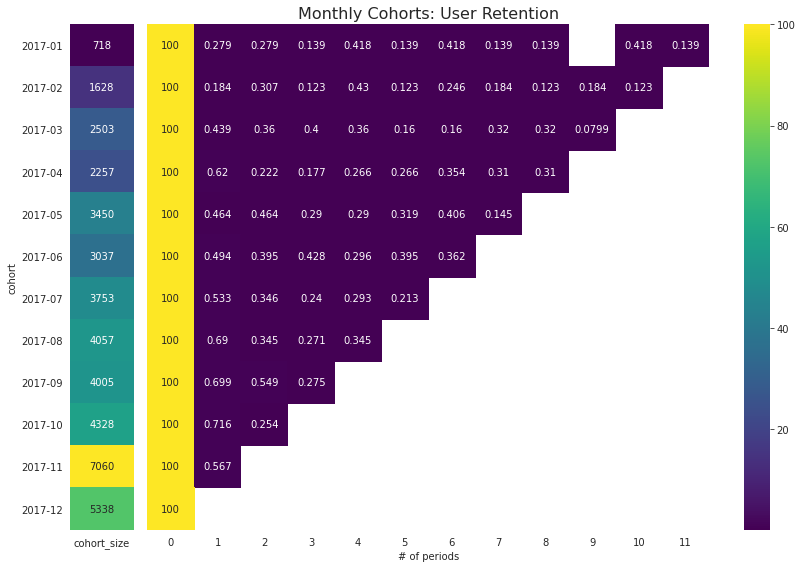

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.3g',
                cmap="viridis",
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap="viridis",
                ax=ax[0])

    fig.tight_layout()

Мы видим, что при вводной "покупка = дата доставки + статус", наибольший ретеншн за 3й месяц приходится на когорту 2017 - 06. Однако нельзя не заметить, что по всему периоду по всем когортам ретеншн крайне невелик.

### RFM-сегментация пользователей

- recency - насколько недавно была совершена последняя покупка клиента (количество дней с момента последней покупки),  
- frequency - как часто клиент совершает покупку (количество покупок за исследуемый период (обычно один год)),    
- monetary - сколько денег тратит клиент (общая сумма покупок, сделанных за исследуемый период),  
- найти квинтили для каждого из этих измерений,  
- дайте оценку каждому параметру в зависимости от того, в каком квинтиле он находится,  
- объединить баллы R, F и M, чтобы получить балл RFM,  
- сопоставить оценки RF с сегментами

In [ ]:
# поскольку для расчета показателей RFM нам нужны как айдишники заказов и юников, так и цена, смержим все таблицы
df = df_items_orders.merge(df_customers)

In [ ]:
# общая дата по совершенным покупкам
df = df.query('(order_status == "delivered") & (order_delivered_customer_date == order_delivered_customer_date)')

In [ ]:
# посмотрим на общие суммы заказов в разрезе пользователей и дат
df = df.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index = False) \
.agg({'price' : 'sum'})

In [ ]:
print('Рассматриваемый период с {} по {}'.format(df1['order_purchase_timestamp'].min(),
                                    df1['order_purchase_timestamp'].max()))

Рассматриваемый период с 2017-08-30 15:01:26 по 2018-08-29 15:00:37


In [ ]:
period = 365

In [ ]:
# так как данные старые, возьмем последнюю дату, от которой считается recency, как максимальную дату в полученном датасете + 1
last_date = df['order_purchase_timestamp'].max() + timedelta(days = 1)

In [ ]:
last_date

Timestamp('2018-08-30 15:00:37')

In [ ]:
# порежем датасет по полученной границе периода
df = df[df['order_purchase_timestamp'] >= last_date - timedelta(days = period)]

In [ ]:
# проверим
df.order_purchase_timestamp.min()

Timestamp('2017-08-30 15:01:26')

In [ ]:
df.order_purchase_timestamp.max()

Timestamp('2018-08-29 15:00:37')

In [ ]:
# посчитаем разницу между концом периода и датой заказа
df['diff_days'] = df.order_purchase_timestamp.apply(lambda x: (last_date - x).days)

In [ ]:
df

,customer_unique_id,order_id,order_purchase_timestamp,price,diff_days
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90,115
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00,288
5,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,2018-04-05 19:33:16,154.00,146
...,...,...,...,...,...
96462,fffa431dd3fcdefea4b1777d114144f2,4f8c4fa99a873ffb8452acc0e0c9c515,2017-10-30 20:39:50,64.99,303
96463,fffb09418989a0dbff854a28163e47c6,1f5bb5f84797dd4e234479124128b9cc,2017-12-17 19:14:35,58.00,255
96464,fffbf87b7a1a6fa8b03f081c5f51a201,64397307c6954ae1ad2ad8e791ad8a31,2017-12-27 22:36:41,149.00,245
96466,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89,262


In [ ]:
# recency - насколько недавно была совершена последняя покупка клиента (количество дней с момента последней покупки минимальное):
df_recency = df.groupby('customer_unique_id', as_index = False) \
.agg({'diff_days' : 'min'}) \
.rename(columns = {'diff_days' : 'recency'})

In [ ]:
# frequency - как часто клиент совершает покупку (количество покупок за исследуемый период):
df_frequency = df.groupby('customer_unique_id', as_index = False) \
.agg({'order_id' : 'count'}) \
.rename(columns = {'order_id' : 'frequency'})

In [ ]:
# monetary - сколько денег тратит клиент (общая сумма покупок, сделанных за исследуемый период):
df_monetary = df.groupby('customer_unique_id', as_index = False) \
.agg({'price' : 'sum'}) \
.rename(columns = {'price' : 'monetary'})

In [ ]:
df_rec_freq = df_recency.merge(df_frequency)

In [ ]:
df_rfm = df_rec_freq.merge(df_monetary)

In [ ]:
df_rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,146,1,154.00


### Исследуем метрики для определения кластеров

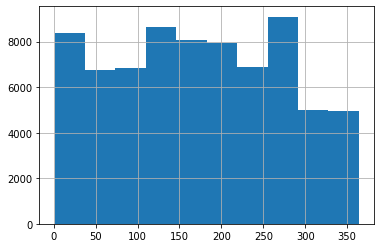

In [ ]:
df_rfm.recency.hist()

In [ ]:
df_rfm.recency.describe()

count    72456.000000
mean       173.162085
std         99.777739
min          1.000000
25%         88.000000
50%        172.000000
75%        261.000000
max        364.000000
Name: recency, dtype: float64

recency - показатель удаленности последней покупки. Получается, что у 25% наших клиентов последний заказ был в течение последних трех месяцев, у 50% - в последние полгода, у 75% - в последние 7 месяцев, и у оставшихся - в первое полугодие. Видится три явных группы:  
- 0,25 (полседние три месяца купили),
- 0,5 (покупка в последние полгода),  
- и оставшиеся (покупка в первое полугодие).

In [ ]:
rec = df_rfm.recency.quantile([.25, .5]).to_dict()

In [ ]:
rec

{0.25: 88.0, 0.5: 172.0}

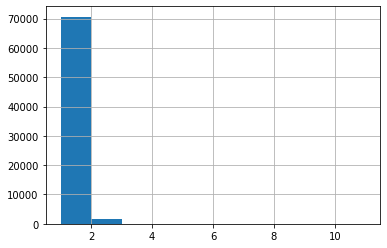

In [ ]:
df_rfm.frequency.hist()

In [ ]:
df_rfm.frequency.describe()

count    72456.000000
mean         1.027217
std          0.185691
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: frequency, dtype: float64

In [ ]:
df_rfm.query('frequency > 1').value_counts('frequency')

frequency
2     1680
3       94
4       16
5        5
7        3
11       1
9        1
dtype: int64

frequency - как часто клиент совершает покупку. Группы в разрезе frequency наблюдаются такими:  
- 1 покупка (наибольшая группа),  
- 2 покупки,  
- 3 и более покупок

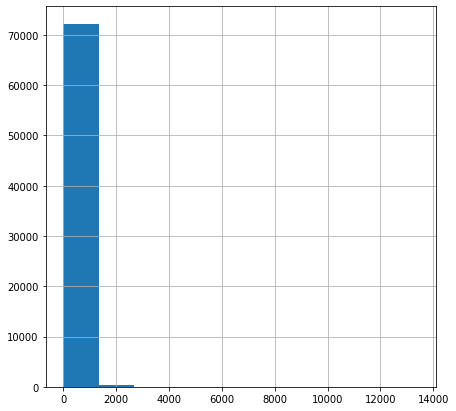

In [ ]:
fig = plt.figure(figsize = (7,7))
ax = fig.gca()
df_rfm.monetary.hist(ax = ax)

In [ ]:
df_rfm.monetary.describe()

count    72456.000000
mean       141.036199
std        211.778033
min          0.850000
25%         47.900000
50%         89.800000
75%        152.000000
max      13440.000000
Name: monetary, dtype: float64

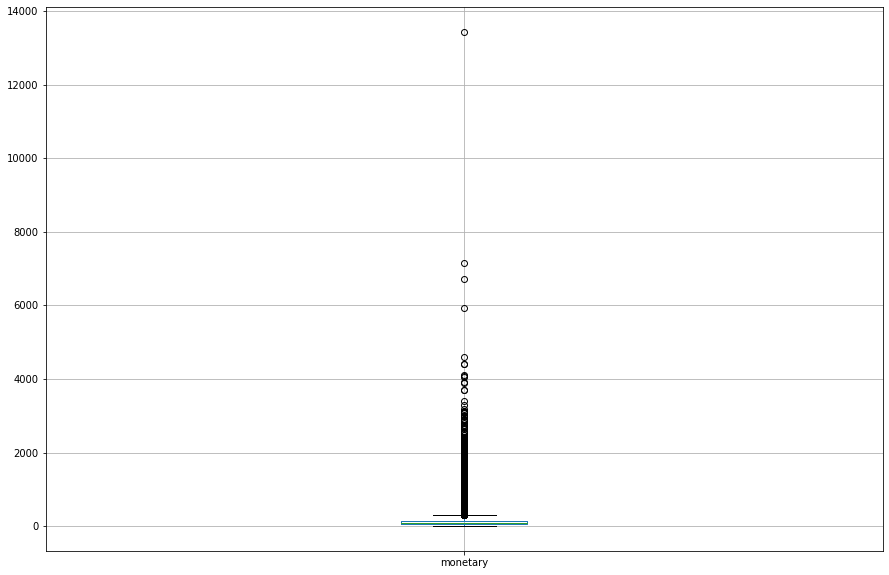

In [ ]:
fig = plt.figure(figsize = (15,10))
df_rfm.boxplot('monetary')

monetary - сколько денег тратит клиент. А клиент тратит по-разному:  
- наибольшая группа до 152,  
- вторая группа от 153 до 5000,
- третья группа более 5000 (выбросы)
Можно было бы и не делить между собой вторую и третью группы, но например это разделение можно использовать в программе лояльности, разные группы клиентов получают разные скидки(тут еще конечно надо смотреть остальные сегменты клиентов третьей группы)

### Расчет баллов RFM

In [ ]:
def r_score(x):
    if x <= rec[.25]:
        return 1
    elif x > rec[.5]:
        return 3
    else:
        return 2

def f_score(x):
    if x == 1:
        return 3
    elif x > 2:
        return 1
    else:
        return 2

def m_score(x):
    if x <= 152:
        return 3
    elif x > 5000:
        return 1
    else:
        return 2

In [ ]:
# внесем в датафрейм колонки со скорами:
df_rfm['r_score'] = df_rfm.recency.apply(lambda x: str(r_score(x)))
df_rfm['f_score'] = df_rfm.frequency.apply(lambda x: str(f_score(x)))
df_rfm['m_score'] = df_rfm.monetary.apply(lambda x: str(m_score(x)))

In [ ]:
# создадим колонку с указанием общего кластера
df_rfm['cluster'] = df_rfm.r_score + df_rfm.f_score + df_rfm.m_score

In [ ]:
df_rfm.cluster.value_counts()

333    26884
133    13459
233    13314
332     8466
232     4370
132     4159
322      450
323      324
122      285
222      256
123      194
223      171
212       37
112       36
312       28
213        8
113        6
313        5
331        2
131        2
Name: cluster, dtype: int64

In [ ]:
df_rfm.cluster.nunique()

20

Итак, всего у нас получилось 20 кластеров. Большинство наших клиентов попали в RFM 333 (давнишние мелкие заказы). Также в топ-3 групп входят клиенты RFM 133 (мелкие заказы, сделанные в последние три месяца) и RFM 233 (мелкие заказы давности от 3 месяцев до полугода). Идеальная группа - RFM 111 (свежие крупные заказы в большом количестве), у нас она отсутствует вобще.